The purpose of the notebook is to use machine learning to see if I can come up with a predictor for the change in [SymH](http://wdc.kugi.kyoto-u.ac.jp/aeasy/). What I expect to see is that the best predictor will be IMF Bz, which we know that southward turnings can drive geomagnetic storms. 

First this code will read in the SW data files into a single pandas data frame that can be used for the ML programs. The SW data files from CDAWeb has additional information and meta data to make sure the files are useful for future generations. I'll just pull our the stuff that is relevant for my playing here, but anyone interested can read all you want at the [CDAWeb site](https://cdaweb.gsfc.nasa.gov/index.html/). I am going to grab the data from OMNI (shifted solar wind data) and the following fields:

- time (this is automatically included)
- Bx
- By
- Bz
- Flow speed
- vx
- vy
- vz
- proton density
- flow pressure
- SymH

I am also going to use 1 minute time resolution. Note that there will be data gaps in some of the fields, so I'll have to handle that as well. I have been downloading these files by hand. I had a code that would go to the website and download data files, but it recently started giving me errors. I believe there may have been a formatting change to the website, so I will have to go look at that later.

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy

Now read in the contents of the data directory. I have a number of *.txt files, so I want to read though the list of the files, read in each file, and concatenate them together.

In [2]:
mypath = "../SW_data/"
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
data = pd.read_csv(mypath + files[0], sep = '\s+', engine='python',skiprows = 73, skipfooter=3, header=None, 
                   names=['date', 'time', 'bx', 'by', 'bz', 'flow_speed', 
                          'vx', 'vy', 'vz', 'H_den', 'Pdyn', 'SymH'])
for f in files[1:]:
    data2 = pd.read_csv(mypath + f, sep = '\s+', engine='python', skiprows = 73, skipfooter = 3, header=None, 
                                           names=['date', 'time', 'bx', 'by', 'bz', 'flow_speed', 
                                                  'vx', 'vy', 'vz', 'H_den', 'Pdyn', 'SymH'])
    data = pd.concat([data, data2])
    

Now that we have the data read in, we will need to handle the bad data. These will be for times that for whatever reason there is no data. Luckily these are already flagged for us, sort of. The followin values indicate bad data:

- Magnetic field, 9999.99
- Flow speed, 99999.9
- velocity vector, 99999.9
- Proton density, 999.99
- Dynamic pressure, 99.99
- SymH, 99999

We will replace the flagged data with NaN. Since some of the values come from the same instrument, we don't need to search every value. For example, knowing one component of the B field is sufficient. So copy the rows that do not have bad values.

In [4]:
data = data.where((data['flow_speed']!=99999.9) & 
                  (data['bx']!=9999.99) &
                  (data['vx']!=9999.99) &
                  (data['H_den']!=999.99) &
                  (data['SymH']!=99999))

In [5]:
del data['date']
del data['time']

Now define the values that I am working to predict. I am giong to use the SW and current SymH values to predict the change in SymH. I guess I could have easily have predicted the next value, but either way should be equivalent. The change will be the value d_SymH.  I also have removed the date and time, since they will not have an effect on the SymH values.

In [6]:
data['d_SymH'] = data['SymH'].shift(periods=-1) - data['SymH']


In [7]:
dd = data[data['d_SymH'].notnull()]

Now make a few quick plots to look at what I have here. Use matplotlib to do the plotting.

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

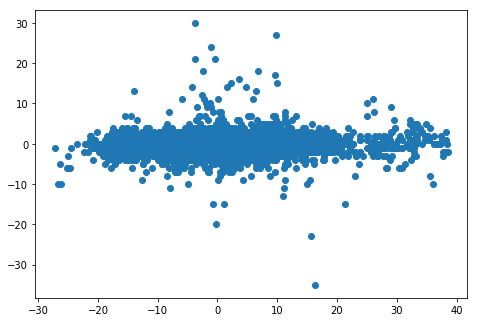

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(dd['bz'], dd['d_SymH'])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-35.   , -33.375, -31.75 , -30.125, -28.5  , -26.875, -25.25 ,
        -23.625, -22.   , -20.375, -18.75 , -17.125, -15.5  , -13.875,
        -12.25 , -10.625,  -9.   ,  -7.375,  -5.75 ,  -4.125,  -2.5  ,
         -0.875,   0.75 ,   2.375,   4.   ,   5.625,   7.25 ,   8.875,
         10.5  ,  12.125,  13.75 ,  15.375,  17.   ,  18.625,  20.25 ,
         21.875,  23.5  ,  25.125,  26.75 ,  28.375,  30.   ]),
 array([-150. , -142.6, -135.2, -127.8, -120.4, -113. , -105.6,  -98.2,
         -90.8,  -83.4,  -76. ,  -68.6,  -61.2,  -53.8,  -46.4,  -39. ,
         -31.6,  -24.2,  -16.8,   -9.4,   -2. ,    5.4,   12.8,   20.2,
          27.6,   35. ,   42.4,   49.8,   57.2,   64.6,   72. ,   79.4,
          86.8,   94.2,  101.6,  109. ,  116

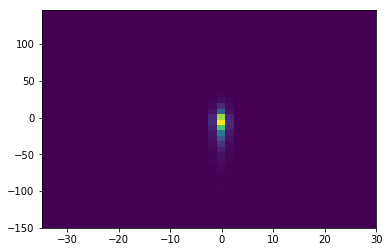

In [13]:
plt.hist2d(dd['d_SymH'], dd['SymH'], bins = 40)

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        5.00000e+00, 1.10000e+01, 4.40000e+01, 4.40000e+01, 4.52000e+02,
        4.05650e+04, 2.76403e+05, 4.11810e+04, 2.75000e+02, 1.15000e+02,
        3.00000e+01, 6.00000e+00, 7.00000e+00, 6.00000e+00, 2.00000e+00,
        5.00000e+00, 1.00000e+00, 3.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-35.   , -33.375, -31.75 , -30.125, -28.5  , -26.875, -25.25 ,
        -23.625, -22.   , -20.375, -18.75 , -17.125, -15.5  , -13.875,
        -12.25 , -10.625,  -9.   ,  -7.375,  -5.75 ,  -4.125,  -2.5  ,
         -0.875,   0.75 ,   2.375,   4.   ,   5.625,   7.25 ,   8.875,
         10.5  ,  12.125,  13.75 ,  15.375,  17.   ,  18.625,  20.25 ,
         21.875,  23.5  ,  25.125,  26.75 ,  28.375,  30.  

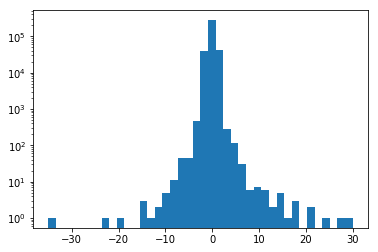

In [14]:
plt.hist(dd['d_SymH'], bins = 40, log=True)

OK, here is a problem. The vast majority of the values for $\Delta$SymH are near zero, or $\pm$1. From the plot above we see that the probablity of having a shift >|2| is down many orders of magnitude. I expect that since there is not very much variation in $\Delta$SymH the model will have a hard time predicting its change.

Now I have the data sorted out. If I had and categoriccal data, I could have used the .get_dummies() funcition from Pandas. Now load the scikit learn packages, 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib

Now break up the data frame into a features matrix and a matrix of the values to search for.

In [16]:
Y = dd['d_SymH'].values
features_df = dd

In [17]:
del features_df['d_SymH']

In [18]:
X = features_df.values

In [19]:
Y

array([0., 1., 1., ..., 1., 0., 0.])

In [20]:
X

array([[  0.26,   0.98,  -0.08, ...,   6.35,   1.74, -12.  ],
       [ -0.28,   2.08,  -0.97, ...,   6.11,   1.65, -12.  ],
       [  0.7 ,   2.26,  -0.39, ...,   7.25,   1.95, -11.  ],
       ...,
       [  2.35,  -1.5 ,   0.22, ...,   1.94,   0.49, -10.  ],
       [  2.33,  -1.53,   0.22, ...,   2.07,   0.52,  -9.  ],
       [  2.54,  -1.08,   0.28, ...,   2.09,   0.52,  -9.  ]])

Now split the data into a training and test sets. I'll use the standard 70% training and 30% test ratio

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

The next bit of code is where the model is run. First lets try a gradient boosting regressor.

In [22]:
model = ensemble.GradientBoostingRegressor(
    n_estimators = 1000,
    learning_rate=0.1,
    max_depth=6,
    min_samples_leaf=9,
    max_features=0.1,
    loss='huber'
    )

model.fit(X_train, Y_train)

#save the data
joblib.dump(model, 'Trained_DeltaSymH_classifer_model.pkl')

['Trained_DeltaSymH_classifer_model.pkl']

Now calculate the error rates on the training set and the test set

In [23]:
mse_train = mean_absolute_error(Y_train, model.predict(X_train))
mse_test  = mean_absolute_error(Y_test,  model.predict(X_test))

In [24]:
print("Training set mean absolute error: %.4f" % mse_train)
print("Test set mean absolute error: %.4f" % mse_test)

Training set mean absolute error: 0.2540
Test set mean absolute error: 0.2713
